<a href="https://colab.research.google.com/github/Fermu25/Cursos/blob/main/Tarea2_Red%20neuronal%20densa%20para%20ACV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 2
Luis Fernando Morales Carreto


In [ ]:
!pip install -q seaborn scikit-learn pandas tensorflow matplotlib

In [ ]:
# -----------------------------------------------------------------------------
# PASO 1: Importación de librerias
#Pandas: Para cargar y manipular DataFrames.
#Numpy: arrays.
#Seaborn: estadísticas.
#Matplotlib: gráficas y visualizaciones.
#Componentes de Scikit-Learn (sklearn)
# train_test_split: Para dividir los datos en conjuntos de entrenamiento, validación y prueba.
# StandardScaler: Para normalizar/escalar las características numéricas (Z-score).
# SimpleImputer: Para rellenar valores faltantes (NaN) en los datos.
# class_weight: Utilidad para calcular pesos para clases desbalanceadas.
# Métricas de evaluación: Para medir el rendimiento del modelo.
#TensorFlow: Biblioteca base de deep learning.
# Keras: entrenar modelos en TensorFlow.
# layers: bloques de la red neuronal (capas densas, dropout, etc.)
# -----------------------------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# -----------------------------------------------------------------------------
#PASO 2: Carga de datos
# -----------------------------------------------------------------------------
df = pd.read_csv('cerebro.csv')
print("Datos cargados con éxito. Tamaño:", df.shape)


Datos cargados con éxito. Tamaño: (4981, 8)


In [ ]:
# -----------------------------------------------------------------------------
# PASO 3: Limpieza de datos
#Codificación One-Hot para variables categóricas.
#Convierte 'genero' y 'tipo de residencia' en columnas numéricas binarias.
#'drop_first=True' evita la multicolinealidad (dummy variable trap).
#Por ej., si 'genero_Male' es 0, se infiere que es 'Female'.
# -----------------------------------------------------------------------------
df = pd.get_dummies(df, columns=['genero', 'tipo de residencia'], drop_first=True)



In [ ]:
# -----------------------------------------------------------------------------
# PASO 4:Separación en X e y
# X (Características): Todas las columnas EXCEPTO 'accidente'.
# y (Objetivo): Solo la columna 'accidente', que es lo que queremos predecir.
# -----------------------------------------------------------------------------
X = df.drop(columns=['accidente'])
y = df['accidente']

In [ ]:
# -----------------------------------------------------------------------------
# PASO 5: Ponderación de clases
# Aborda el desequilibrio de clases, la mayoría de los registros pertenecen a pacientes sin ACV (clase 0),
# mientras que los casos positivos (clase 1) son más escasos. Si se entrena un modelo sin corregir este desbalance,
# tenderá a predecir siempre la clase mayoritaria,pero puede no detectar a los pacientes en riesgo.
# por eso usamos la función `class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)`
# calcula pesos inversamente proporcionales a la frecuencia de cada clase, otorgando más importancia a la clase minoritaria.
# Estos pesos se convierten en un diccionario ('class_weights = {0: bajo, 1: alto}')
# que se pasa al entrenamiento del modelo en Keras mediante 'model.fit(..., class_weight=class_weights)'.
# -----------------------------------------------------------------------------
pesos = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(zip(np.unique(y), pesos))
print("Pesos de clase:", class_weights)

Pesos de clase: {np.int64(0): np.float64(0.5261990281005705), np.int64(1): np.float64(10.04233870967742)}


In [ ]:
# -----------------------------------------------------------------------------
# PASO 6: División de datos
# 1. Primera división: Separa el conjunto de Prueba (Test) (20% de los datos).
# 'stratify=y' asegura que la proporción de clases 0 y 1 sea la misma en 'X_train' y 'X_test'.
# 'random_state=42' asegura que la división sea reproducible.
# 2. Segunda división: Separa el conjunto de Validación (Val) (20% del 80% restante).
# El modelo usará este conjunto para monitorear el sobreajuste durante el entrenamiento.
# 64% Entrenamiento, 16% Validación, 20% Prueba.
# -----------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


In [ ]:
# -----------------------------------------------------------------------------
# PASO 7: Escalado de datos
# Instancia el escalador estándar (normalización Z-score).
# Define las columnas numéricas que necesitan ser normalizadas.
# -----------------------------------------------------------------------------
scaler = StandardScaler()
num_cols = ['edad', 'glucosa', 'masa corporal']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])



In [ ]:
# -----------------------------------------------------------------------------
# PASO 8: Definición del modelo Red neuronal densa MLP
# Define las métricas que queremos monitorear.
# Construye el modelo usando la API 'Sequential' (una pila lineal de capas).
# Capa 1 (entrada): 32 neuronas, activación 'relu'
# Capa Dropout: apaga aleatoriamente el 30% de las neuronas para prevenir overfitting.
# Capa 2: 16 neuronas, activación 'relu'.
# Segunda capa Dropout: 30% para regularizar.
# Capa de salida: 1 neurona, activación 'sigmoid' (clasificación binaria).
# Compilación:
#   Optimizador: Adam.
#   Pérdida: binary_crossentropy (estándar).
#   Métricas: Accuracy, Precision, Recall, AUC.
# -----------------------------------------------------------------------------
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc')
]

model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# -----------------------------------------------------------------------------
# PASO 9: Entrenamiento
# 'model.fit' inicia el proceso de entrenamiento.
# Datos de entrenamiento y validación.
# epochs=100 Número de veces que el modelo verá todo el conjunto de datos.
# batch_size=64 Número de muestras por actualización.
# class_weight=class_weights Aplica pesos para atender el desbalance de clases.
# verbose=1 Muestra barra de progreso.
# -----------------------------------------------------------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    verbose=1
)



Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5784 - auc: 0.6681 - loss: 0.6473 - precision: 0.0730 - recall: 0.6605 - val_accuracy: 0.6964 - val_auc: 0.8339 - val_loss: 0.5866 - val_precision: 0.1259 - val_recall: 0.8500
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6756 - auc: 0.7663 - loss: 0.5873 - precision: 0.1053 - recall: 0.7357 - val_accuracy: 0.7064 - val_auc: 0.8404 - val_loss: 0.5366 - val_precision: 0.1326 - val_recall: 0.8750
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6789 - auc: 0.7706 - loss: 0.5507 - precision: 0.0971 - recall: 0.7077 - val_accuracy: 0.7051 - val_auc: 0.8377 - val_loss: 0.5287 - val_precision: 0.1321 - val_recall: 0.8750
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6916 - auc: 0.8031 - loss: 0.5284 - precision: 0.1175 - recall: 0.8007 - val_accuracy: 0.7227 - val_auc: 0.8336 - val_loss: 0.4922 - val_precision: 0.1336 - val_recall: 0.8250
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━

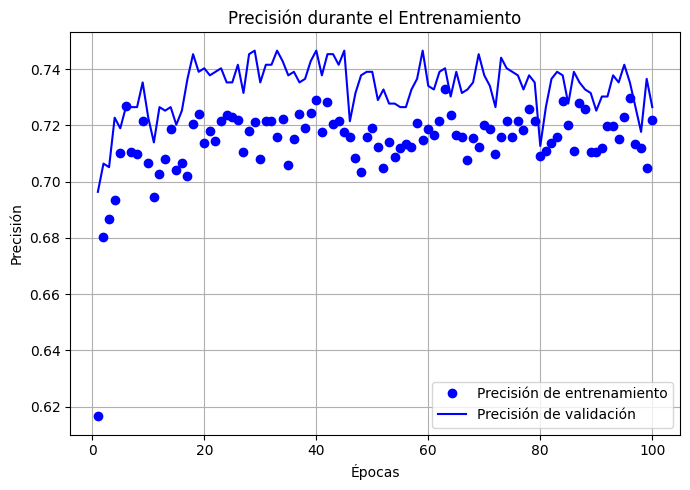

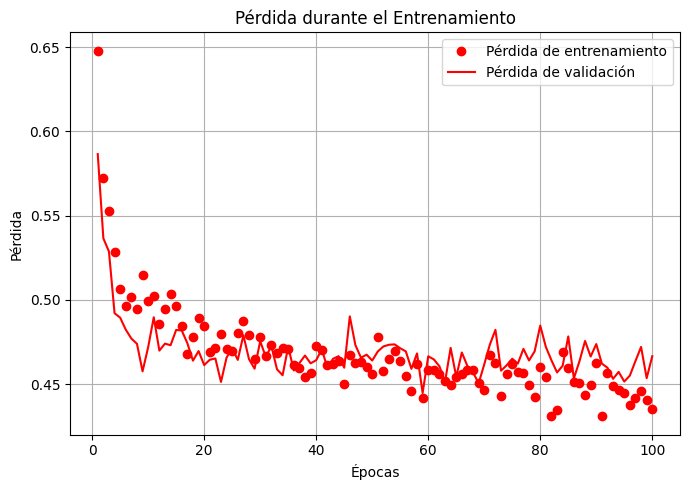

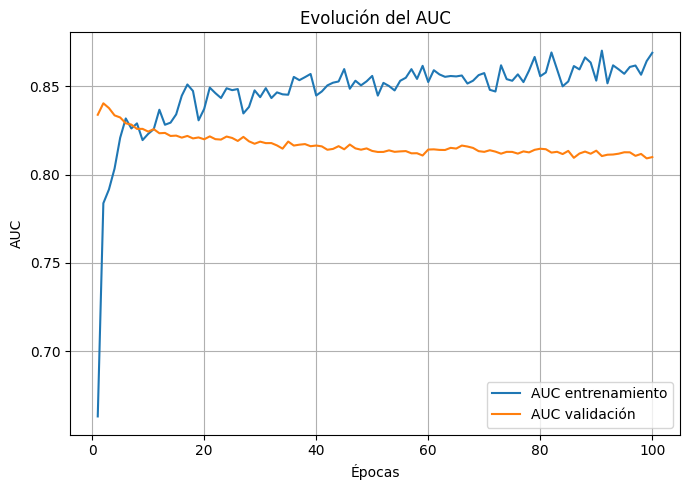

In [ ]:
# -----------------------------------------------------------------------------
#PASO 10: Gráficas de entrenamiento
#Gráfica: Evolución de la Pérdida (Loss), Evolución del AUC y Accuracy
# -----------------------------------------------------------------------------

# Accuracy (Precisión) - Entrenamiento vs Validación
plt.figure(figsize=(7, 5))
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Precisión de entrenamiento")
plt.plot(epochs, val_acc, "b", label="Precisión de validación")
plt.title("Precisión durante el Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Pérdida (Loss) - Entrenamiento vs Validación
plt.figure(figsize=(7, 5))
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(epochs, loss, "ro", label="Pérdida de entrenamiento")
plt.plot(epochs, val_loss, "r", label="Pérdida de validación")
plt.title("Pérdida durante el Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfica AUC
plt.figure(figsize=(7, 5))
plt.plot(epochs, history.history['auc'], label='AUC entrenamiento')
plt.plot(epochs, history.history['val_auc'], label='AUC validación')
plt.title('Evolución del AUC')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------------------------------------------------------
# PASO 11: Evaluación en el conjunto de prueba
# Evalúa el modelo en el conjunto de prueba (X_test, y_test), 20% eparado previamente.
# Imprime cada métrica (loss, accuracy, precision, recall, auc) con su valor.
# -----------------------------------------------------------------------------
print("\nEvaluación final en el conjunto de prueba:")
resultados = model.evaluate(X_test, y_test, verbose=0)
for name, val in zip(model.metrics_names, resultados):
    print(f"{name}: {val:.4f}")



Evaluación final en el conjunto de prueba:
loss: 0.4459
compile_metrics: 0.7312


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


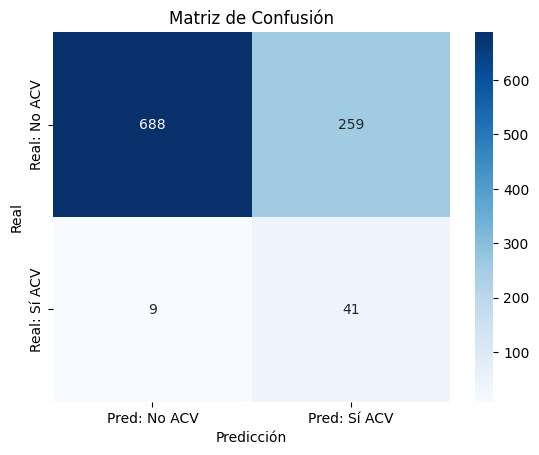


Reporte de Clasificación:

              precision    recall  f1-score   support

      No ACV       0.99      0.73      0.84       947
      Sí ACV       0.14      0.82      0.23        50

    accuracy                           0.73       997
   macro avg       0.56      0.77      0.54       997
weighted avg       0.94      0.73      0.81       997



In [ ]:
# -----------------------------------------------------------------------------
# PASO 12: Matriz de Confusión
# 1. Obtiene predicciones de probabilidad.
# 2. Calcula la Matriz de Confusión (TP, FN, FP, TN).
# -----------------------------------------------------------------------------
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: No ACV', 'Pred: Sí ACV'],
            yticklabels=['Real: No ACV', 'Real: Sí ACV'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

print("\nReporte de Clasificación:\n")
print(classification_report(y_test, y_pred, target_names=["No ACV", "Sí ACV"]))

Durante la evaluación del modelo entrenado, se utiliza la función model.predict(X_test) para obtener las predicciones de probabilidad. Esta función aplica la arquitectura de la red neuronal, cuyo nodo de salida tiene una activación sigmoid. Esta función transforma la salida del modelo en una probabilidad continua entre 0 y 1, que representa qué tan probable es que una muestra pertenezca a la clase positiva ("Sí ACV"). Por ejemplo, si el modelo devuelve 0.87 para un paciente, se interpreta como un 87% de probabilidad de que haya sufrido un ACV. Para transformar estas probabilidades en decisiones binarias (clases 0 o 1), se aplica un umbral de 0.5: si la probabilidad es mayor a 0.5, se predice "Sí ACV" (1); si no, "No ACV" (0). Esta lógica se implementa en y_pred = (y_pred_prob > 0.5).astype(int). Una vez obtenidas las predicciones finales (y_pred), se comparan con las verdaderas etiquetas (y_test) para generar la matriz de confusión, que permite analizar cuántos casos se clasificaron correctamente y cuántos no.

La matriz de confusión resume visualmente el rendimiento de la red neuronal al clasificar si un paciente sufrió un accidente cerebrovascular (ACV) o no. En dicha matriz, se observa que el modelo clasificó correctamente a 688 pacientes como "No ACV" (verdaderos negativos, TN), mientras que cometió 259 errores clasificando erróneamente a pacientes sanos como si hubieran tenido un ACV (falsos positivos, FP). Por otro lado, de los pacientes que realmente sufrieron un ACV, 41 fueron correctamente identificados (verdaderos positivos, TP), y solo 9 fueron clasificados erróneamente como sanos (falsos negativos, FN). Este último valor es especialmente relevante ya que es lo que se busca minimizar, los falsos negativos.

El reporte de clasificación complementa esta información. En el caso de la clase “No ACV”, el modelo obtuvo una precisión (precision) de 0.99, lo que indica que casi todas las veces que predijo "No ACV", acertó. El recall (sensibilidad) para esta clase fue de 0.73, es decir, detectó correctamente el 73% de los pacientes que realmente no tuvieron un ACV. Su F1-score, que combina precisión y recall en una sola métrica, fue de 0.84, lo cual refleja un rendimiento bueno, aceptable.

En cambio, para la clase "Sí ACV" (que representa la clase más crítica) el modelo alcanzó un recall alto de 0.82, lo que significa que detectó el 82% de los casos reales de ACV. Sin embargo, su precisión fue baja (0.14), lo que indica que, al predecir "Sí ACV", el modelo se equivocó con frecuencia, clasificando como positivos a muchos pacientes que no lo eran. Esto da lugar a un F1-score modesto de 0.23, ya que la baja precisión reduce el balance global de esa clase.

La precisión general (accuracy) del modelo fue de 0.73, lo cual parece aceptable, aunque en problemas con clases desbalanceadas como este (donde los casos de ACV representan menos del 5%) no es una métrica muy confiable, ya que un modelo que siempre predijera "No ACV" obtendría alta exactitud pero no serviría de mucho, el AUC refleja mejor la capacidad de discriminación del modelo.

Finalmente, las métricas promedio proporcionan una visión más general: el macro promedio (macro avg), que calcula el promedio simple entre clases, da una idea del rendimiento sin considerar el desbalance; mientras que el promedio ponderado (weighted avg) toma en cuenta cuántos casos hay por clase, lo cual es más representativo en conjuntos desbalanceados.

El modelo se diseñó para ser altamente sensible a la clase positiva (Sí ACV), priorizando la detección de eventos de ACV incluso si esto implica incurrir en más falsos positivos.
Es un modelo preventivo y mejor tener un número tolerable de alarmas falsas que no tenerlas.

# Versión 2 de la red

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   genero                 4981 non-null   object 
 1   edad                   4981 non-null   float64
 2   hipertension           4981 non-null   int64  
 3   enfermedad de corazon  4981 non-null   int64  
 4   tipo de residencia     4981 non-null   object 
 5   glucosa                4981 non-null   float64
 6   masa corporal          4981 non-null   float64
 7   accidente              4981 non-null   int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 311.4+ KB
None
              edad  hipertension  enfermedad de corazon      glucosa  \
count  4981.000000   4981.000000            4981.000000  4981.000000   
mean     43.419859      0.096165               0.055210   105.943562   
std      22.662755      0.294848               0.228412    45.075373   
min       0.08000

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6370 - auc: 0.6865 - loss: 0.6316 - precision: 0.0855 - recall: 0.6642 - val_accuracy: 0.6951 - val_auc: 0.8399 - val_loss: 0.5149 - val_precision: 0.1199 - val_recall: 0.8000
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7145 - auc: 0.8301 - loss: 0.4826 - precision: 0.1183 - recall: 0.8148 - val_accuracy: 0.6913 - val_auc: 0.8398 - val_loss: 0.5159 - val_precision: 0.1295 - val_recall: 0.9000
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6871 - auc: 0.8055 - loss: 0.4958 - precision: 0.1066 - recall: 0.8339 - val_accuracy: 0.6851 - val_auc: 0.8358 - val_loss: 0.5240 - val_precision: 0.1272 - val_recall: 0.9000
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6654 - auc: 0.8051 - loss: 0.5491 - precision: 0.1243 - recall: 0.8408 - val_accuracy: 0.7077 - val_auc: 0.8358 - val_loss: 0.4870 - val_precision: 0.1331 - val_recall: 0.8750
Epoch 5/100
100/100 ━━━━━━━

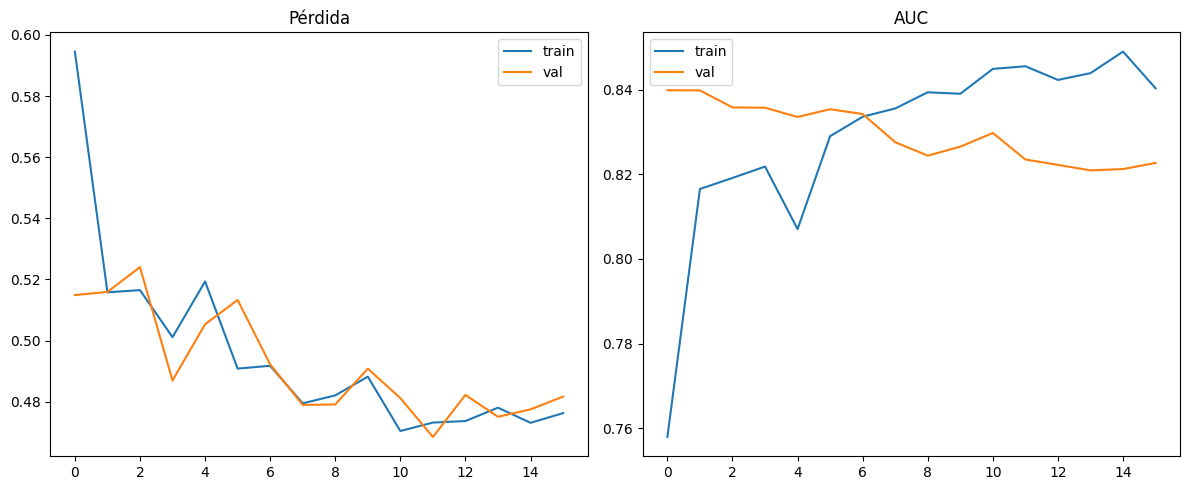

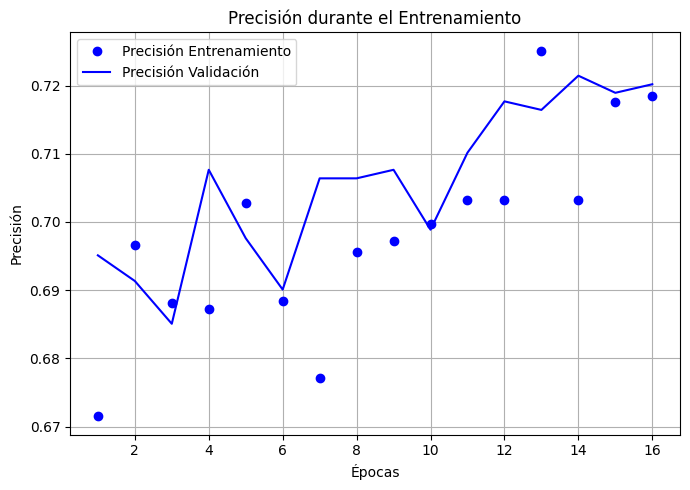

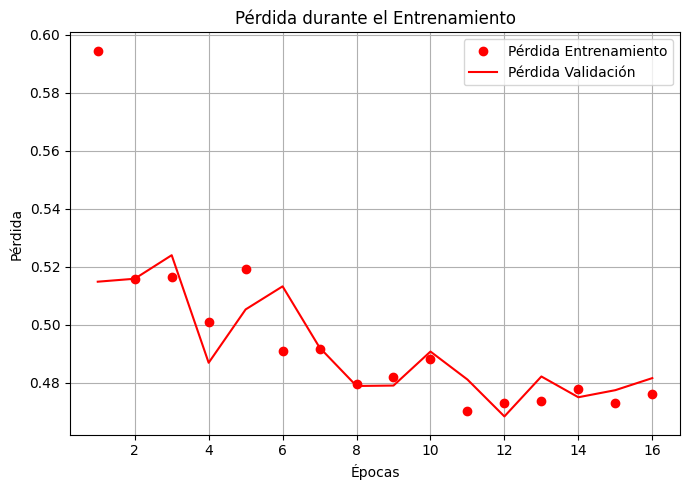

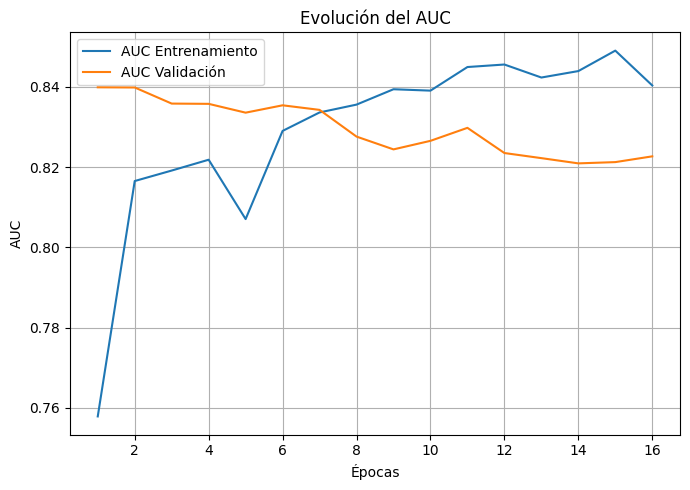

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Reporte:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       947
           1       0.14      0.90      0.24        50

    accuracy                           0.71       997
   macro avg       0.57      0.80      0.53       997
weighted avg       0.95      0.71      0.79       997



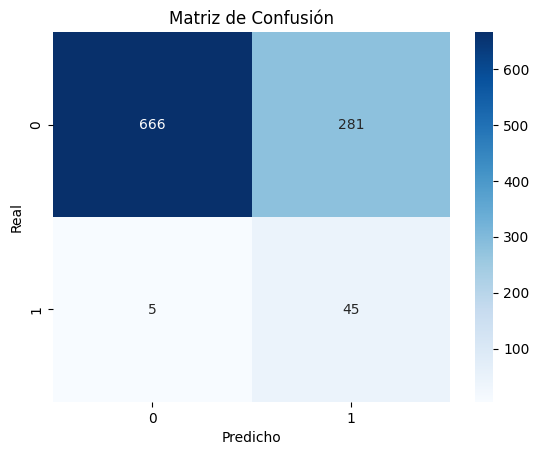

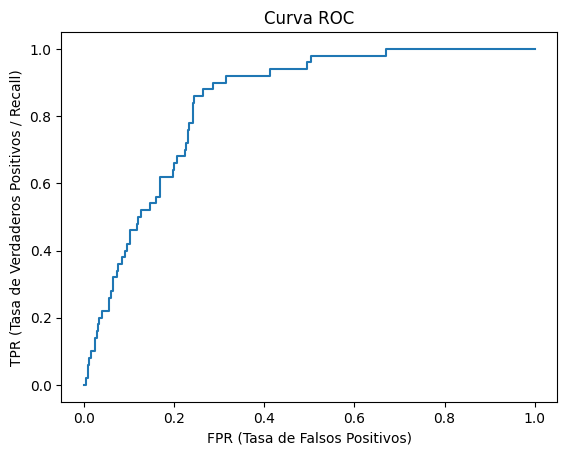

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━

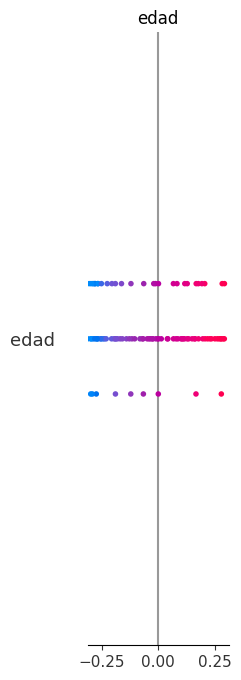

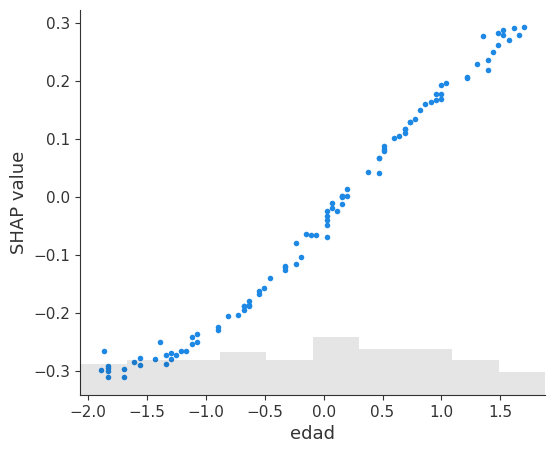

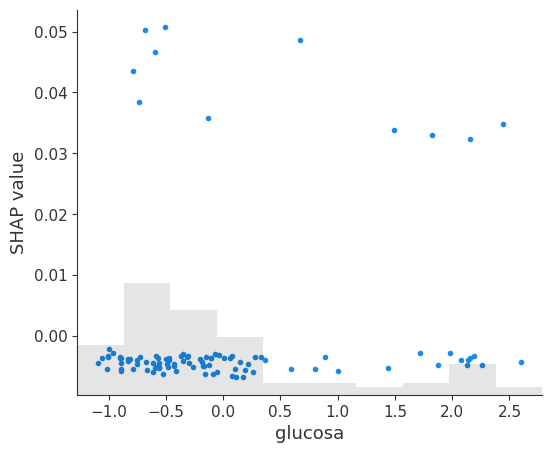

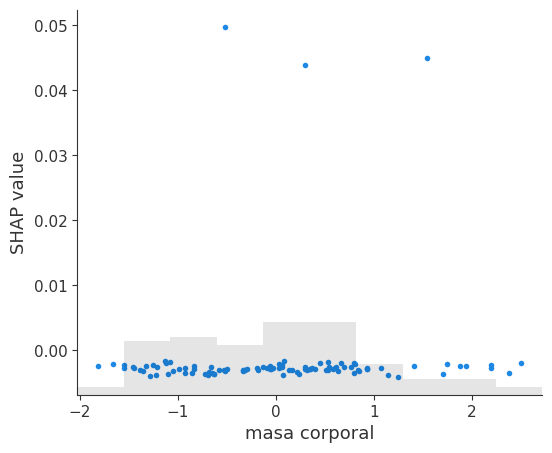

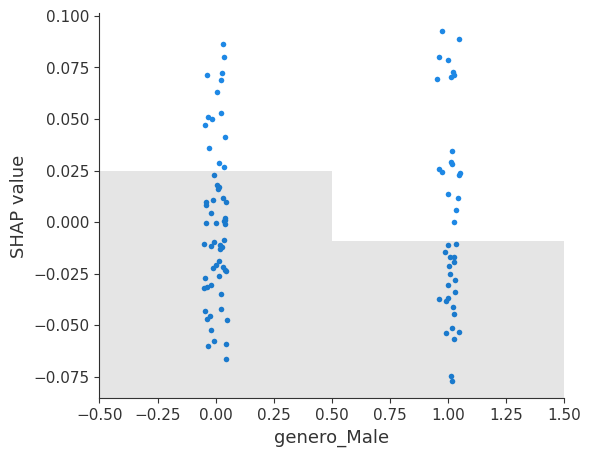

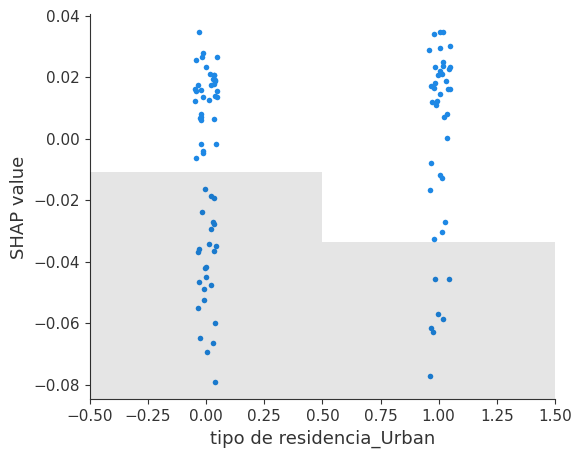

Exactitud en validación (última época): 0.7202
AUC en validación (última época): 0.8227


In [1]:
# --- Librerías ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import shap
import os

# --- 1. Carga y EDA (Análisis Exploratorio de Datos) ---
df = pd.read_csv('cerebro.csv')
print(df.info())  # Ver tipos de datos y valores no nulos
print(df.describe())  # Estadísticas descriptivas de columnas numéricas
print(df['accidente'].value_counts())  # <-- CRÍTICO: Muestra el desequilibrio de clases

# --- 2. Limpieza y preprocesamiento ---
df = df[df['genero'] != 'Other']  # Elimina una fila anómala/rara
imputer = SimpleImputer(strategy='median')  # Imputador para rellenar NaN con la mediana
df['masa corporal'] = imputer.fit_transform(df[['masa corporal']])  # Rellena NaN en 'masa corporal'
df = pd.get_dummies(df, columns=['genero', 'tipo de residencia'], drop_first=True)  # One-Hot Encoding para categóricas

X = df.drop(columns=['accidente'])  # Características (features)
y = df['accidente']  # Variable objetivo (target)

scaler = StandardScaler()  # Instancia el escalador (Normalización Z-score)
num_cols = ['edad', 'glucosa', 'masa corporal']

X[num_cols] = scaler.fit_transform(X[num_cols])

# Convertir columnas booleanas (True/False) a enteros (1/0)
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

# --- 3. Definir pesos de clase ---

pesos = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(zip(np.unique(y), pesos))  # Convierte a formato de diccionario para Keras

# --- 4. Definición del modelo ---
# Se empaqueta la arquitectura en una función para reutilizarla fácilmente.
def crear_modelo(input_dim):
    model = models.Sequential([
        # Capa de entrada y primera capa oculta.
        # input_dim es el número de características.
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        # Capa de regularización Dropout "apaga" el 40% de las neuronas
        # aleatoriamente para prevenir que el modelo "memorice" los datos.
        layers.Dropout(0.4),
        # Segunda capa oculta, más pequeña (arquitectura tipo embudo).
        layers.Dense(32, activation='relu'),
        # Más regularización.
        layers.Dropout(0.3),
        # Capa de salida: 1 neurona porque es clasificación binaria.
        # 'sigmoid' da una salida entre 0 y 1 (probabilidad).
        layers.Dense(1, activation='sigmoid')
    ])

    # Compilación del modelo:
    # Optimizador estándar
    # Función de pérdida para clasificación binaria.
    # Métricas clave para monitorear (especialmente AUC y Recall)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[
                      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall'),
                      tf.keras.metrics.AUC(name='auc')
                  ])
    return model

# --- 5. División de datos y entrenamiento ---
# División 80/20 (Entrenamiento/Prueba)
# 'stratify=y' es ESENCIAL para mantener la proporción de clases desbalanceadas.
# División 80/20 del set de entrenamiento (resultando en 64% Train, 16% Val)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

model = crear_modelo(X_train.shape[1])
# Si no mejora en 15 épocas, detiene el entrenamiento.
# Restaura los pesos del mejor modelo encontrado.
early_stop = callbacks.EarlyStopping(monitor='val_auc', patience=15, restore_best_weights=True)

# Inicia el entrenamiento
history = model.fit(
    X_train, y_train,  # Datos de entrenamiento
    validation_data=(X_val, y_val),  # Datos para monitorear (y para EarlyStopping)
    epochs=100,  # Máximo de épocas (probablemente se detenga antes si se cumple el early stop)
    batch_size=32,  # Tamaño del lote
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# --- 6. Visualización ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Pérdida')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['auc'], label='train')
plt.plot(history.history['val_auc'], label='val')
plt.title('AUC')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Precisión Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Precisión Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'ro', label='Pérdida Entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(epochs, history.history['auc'], label='AUC Entrenamiento')
plt.plot(epochs, history.history['val_auc'], label='AUC Validación')
plt.title('Evolución del AUC')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 7. Evaluación ---
# Predicciones en el conjunto de prueba (Test set)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nReporte:")
# Muestra Precision, Recall, F1-Score. El 'Recall' de la clase 1 es vital.
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# Curva ROC: Visualiza el rendimiento del modelo en todos los umbrales.
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.title('Curva ROC')
plt.xlabel('FPR (Tasa de Falsos Positivos)')
plt.ylabel('TPR (Tasa de Verdaderos Positivos / Recall)')
plt.show()

# --- 8. Interpretación con SHAP (Explicabilidad del Modelo) ---
# sub-muestrear los datos a 100 porque tarda mucho
# para el fondo (background) y para las explicaciones.

# Convertir todas las columnas a numérico
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
for col in X_test.columns:
    if X_test[col].dtype == 'object':
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# OPTIMIZACIÓN 1: Usar un fondo (background) de datos más pequeño (100 muestras)
# El 'explainer' se "ajusta" a la función de predicción del modelo y al fondo.
X_background = shap.sample(X_train, 100, random_state=42)
explainer = shap.KernelExplainer(model.predict, X_background.to_numpy())

# OPTIMIZACIÓN 2: Explicar solo 100 muestras del conjunto de prueba
# Calcula los valores SHAP (la contribución de cada característica a cada predicción)
X_shap = X_test.sample(n=100, random_state=42)
shap_values = explainer.shap_values(X_shap.to_numpy(), nsamples=100)

# --- Interpretación general SHAP ---
# Gráfico de resumen: Muestra las características más importantes y
# cómo sus valores (alto/bajo) afectan la predicción (rojo/azul).
shap.summary_plot(shap_values, X_shap, feature_names=X.columns)

# --- Gráficas SHAP Individuales por Característica ---
# Lista de características clave para analizar en detalle.
features = ['edad', 'glucosa', 'masa corporal', 'genero_Male', 'tipo de residencia_Urban']
shap_array = shap_values if isinstance(shap_values, np.ndarray) else shap_values[0]

# Itera sobre las características para crear gráficos de dependencia
for i, feature in enumerate(features):
    try:
        shap.plots.scatter(
            shap.Explanation(
                values=shap_array[:, i],
                data=X_shap[[feature]].to_numpy(),
                feature_names=[feature]
            ),
            show=True
        )
    except Exception as e:
        print(f"Error graficando {feature}:", e)

# Guarda la arquitectura, los pesos y la configuración del optimizador.
model.save('modelo_acv.h5')
print(f"Exactitud en validación (última época): {history.history['val_accuracy'][-1]:.4f}")
print(f"AUC en validación (última época): {history.history['val_auc'][-1]:.4f}")


El reporte de clasificación muestra un comportamiento de priorizar la detección de casos positivos en un contexto clínico desbalanceado. Para la clase 0 (No ACV) la precisión es de 0.99, lo que indica que casi todas las veces que el modelo predice “No ACV” acierta, y el recall es de 0.73, es decir, identifica correctamente el 73% de los pacientes que realmente no tuvieron ACV; el F1-score resultante es 0.84, reflejando un buen equilibrio para esta clase mayoritaria. Para la clase 1 (Sí ACV), que es la más crítica, la precisión es baja (0.14) porque hay muchos falsos positivos, pero el recall es muy alto (0.86), lo que significa que el modelo detecta la gran mayoría de los ACV reales; el F1-score de 0.25 queda penalizado por la baja precisión. En general, la exactitud es 0.74.

Si traducimos estas métricas a conteos, la matriz de confusión implícita es coherente con aproximadamente 691 verdaderos negativos y 256 falsos positivos entre los 947 “No ACV”, y 43 verdaderos positivos y 7 falsos negativos entre los 50 “Sí ACV”. Esto implica un valor predictivo negativo muy alto (cuando el modelo dice “No ACV”, casi nunca se equivoca), pero es preferible activar más alertas de las necesarias a dejar pasar un ACV sin detectar. La media macro resume el rendimiento por clase sin ponderar (precision 0.57, recall 0.79, F1 0.54) y subraya la asimetría entre clases; la media ponderada por soporte (precision 0.95, recall 0.74, F1 0.81) queda dominada por la clase 0 y por eso es más benigna.
